<img src="./img/QB.png", width="800">

## ACRTA road taxation data engineering challange by Quantumblack
Contest Link: https://datahack.analyticsvidhya.com/contest/quantumblack-online-hackathon/

## Problem Statement

ACRTA road taxation data engineering

Astro City Road transport authority (ACRTA) in US have come up with an idea to use car registration renewal charges to provide indirect incentives to safe drivers. Also, providing subsidies to certain areas as per the extreme climatic conditions in terms of heavy snow or rain.

ACRTA has contacted us to perform a quantitative study and design a prediction model to support the aforementioned applications.

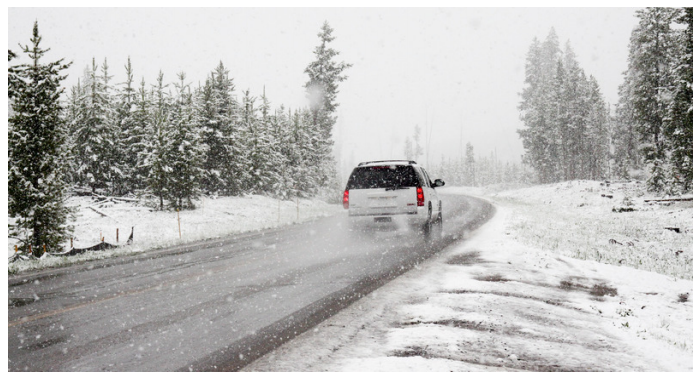

We, being a part of the data engineering team, are working continuously with the business stakeholders as well as data scientists to create features around these scenarios.

Problem statement that we have been provided is to “Develop inputs for a model that predicts the chances of having a vehicle accident based on driving conditions. This model will help the transport authority to understand risk patterns and act upon them.”

This output then would be utilized so as to come up for a risk-based taxation on different drivers and locations as per crash-prone weather conditions.

Use cases would be –

#### Imposing “unsafe driving tax” on drivers to provide a positive feedback loop which may be revisited every year by looking at the past year trip data based on the driving patterns. Lower the tax in the regions where the climatic conditions lead them to become a crash-prone site.

## Data Description

#### 1. Drive Data (Connected car data) – Data coming from the car-mounted devices, which provides you with the car statistics every second. This information will include – Speed, acceleration, engine temperature and other car statistics.

#### 2. Trip – Parameters associated with location of car such as lattitude, longitude, altitude and other similar parameters

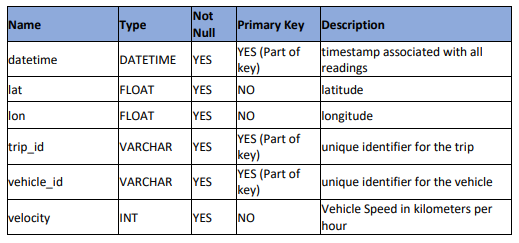

#### 3. Weather – Weather condition at different latitude & longitude during different times each day.

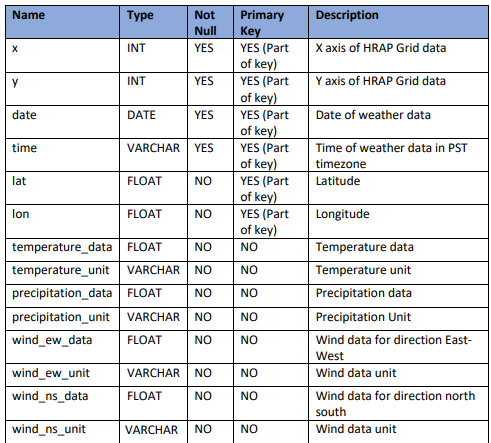

#### 4. Vehicle Specifications – Different vehicle technical specifications which comes from the manufacturer of the car.

## Submission/Output Format

Using the input data as described above, the participant would need to create features related to different hypothesis around the driving behaviours.

Solution file must be a single zip containing the 3 csvs for 3 kinds of features with the file names as given below:

#### Engine Features: engine_features.csv Drive Features: drive_features.csv Weather Features: weather_features.csv The csv files must have the same file names and columns in order so that checks may be done. Failure to do so would result in direct rejection as these would be tested through automated scripts.

To understand the type of features to create, Please go through the requirements for the features carefully:
#### 1. Engine Features (file name – engine_features.csv) 
Grain - every vehicle aggregated at week start date(Monday) for the complete week in YYYY-MM-DD format.

Sorted - by Vehicle ID and week_start_Date in ascending manner

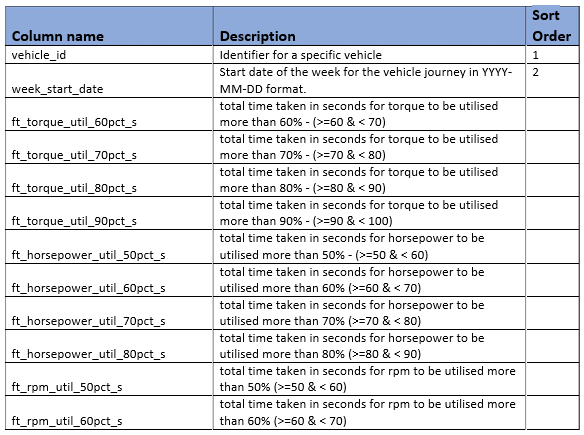

Hints:

Convert timezone to PST before any calculations All vehicles from drive data should be in the final output even if you do not have specifications (Fill with 0 if specs are not given) 
Active horsepower - Engine load / 255 Max Torque RPM / 5252 
Horsepower utilization – Active horsepower / Max Horsepower Torque Utilization - calculated as Engine load/ 255 
RPM Utilization – RPM / Maximum horsepower rpm

#### 2. Drive features(file name – drive_features.csv) 

Grain – Every trip’s aggregated features at a trip id level.

Sorted - by trip_id in ascending manner

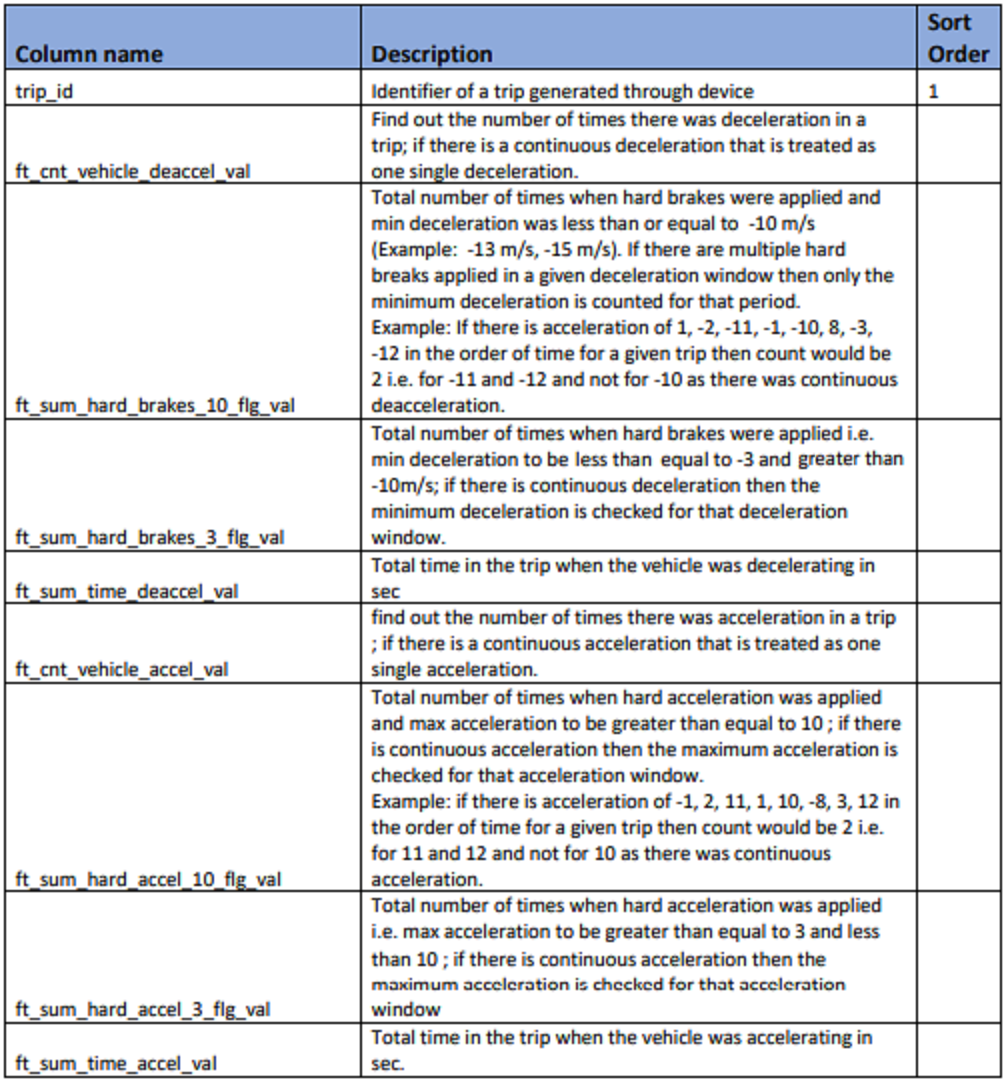

Hints:

Acceleration m/s is calculated as a change in velocity over time If a vehicle keeps on accelerating continuously over a period of time, please treat them as a single acceleration or deacceleration period.

#### 3. Weather features (file name – weather_features.csv) 

Here are the weather conditions for your reference and generating weather feature accordingly

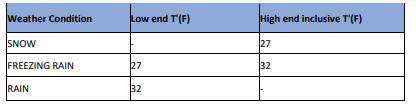

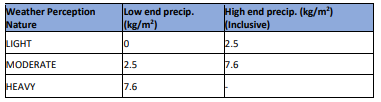

Grain – Every vehicle detail should be aggregated at a week start date.

Sorted - by vehicle_id and week_start_date in ascending manner

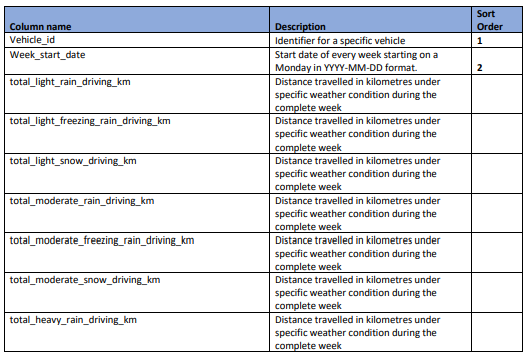

Hint: convert time zone to PST before any calculations

Assumptions & Hints–

Weather data is already in PST and may not need any timezone conversion. You may consider the weather data to be constant for complete hour basis. For example- if the temperature is given to be 284.51 for 2017-02-14 19:00:00, it would be the same for time 2017-02-14 19:15:45 as well. Haversine formula must be utilized to measure the distance between any 2 consecutive points in between the trips. Matches in between datasets must be on geohash precision point 5.

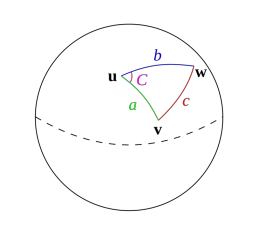

Studies have found that - The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Important in navigation, it is a special case of a more general formula in spherical trigonometry, the law of haversines, that relates the sides and angles of spherical triangles.

# Loading the required libraries

In [12]:
import pandas as pd
import os
import glob
import parquet
import pytz
from datetime import datetime,timedelta
from pytz import timezone
import matplotlib.pyplot as plt
import numpy as np
import pygeohash as gh
import warnings
from haversine import haversine, Unit
warnings.filterwarnings("ignore")

## Reading the data from parquet files

In [2]:
owd = os.getcwd()

In [3]:
path1 = './input_data/weather'
path2 = './input_data/trip'
path3 = './input_data/drive'

def read_data(file_path):
    
    os.chdir (file_path)
    parquet_list=list()
    for filename in glob.glob('*.parquet'):
        parquet_list.append(filename)
        
    df = pd.DataFrame()

    for m in range(0,len(parquet_list)):
        temp = pd.read_parquet(parquet_list[m],engine='fastparquet')
        df = df.append(temp)
    
    del temp
    return df

weather_data = read_data(path1);os.chdir(owd)
trip_data = read_data(path2);os.chdir(owd)
drive_data = read_data(path3);os.chdir(owd)
vehicle_data = pd.read_csv('./input_data/vehicle.csv', low_memory=False);os.chdir(owd)

## Merging Trip and Vehicle Data to Drive Data

In [5]:
os.chdir('./input_data')

drive_data['datetime'] = drive_data['datetime'].dt.tz_localize('US/Pacific')
trip_data['datetime'] = trip_data['datetime'].dt.tz_localize('US/Pacific')
trip_data['geohash'] = trip_data.apply(lambda x: gh.encode(x.lat, x.long, precision = 5),axis = 1)

drive_data = pd.merge(drive_data, trip_data, how='left', on=['vehicle_id','trip_id','datetime'])
#plt.plot(drive_data['velocity_x'],drive_data['velocity_y'])
drive_data['velocity'] = drive_data['velocity_x']
drive_data = drive_data.drop(columns=['velocity_x', 'velocity_y'])

drive_data = drive_data.sort_values(['vehicle_id','trip_id','datetime'], ascending=[True, True, True])    
drive_data['date'] = pd.to_datetime(drive_data['datetime'].astype(str).str[0:10],format = '%Y-%m-%d')

#Merging Vehicle Specification
drive_data = pd.merge(drive_data, vehicle_data, how='left', on=['vehicle_id'])
drive_data.reset_index(level=0, inplace=True)

#checking for NULL
#drive_data.isnull().sum(axis = 0)

drive_data = drive_data.drop(columns=['accel_x','accel_y','accel_z','iat'])

## Calculating Engine Features

In [6]:
drive_data['torque_util'] = drive_data['eng_load'].astype(float) / 255.0
drive_data['rpm_util'] = drive_data['rpm'].astype(float) / drive_data['max_horsepower_rpm'].astype(float)

drive_data['act_hp'] = (drive_data['torque_util'].astype(float) * drive_data['max_torque'].astype(float) * drive_data['rpm'].astype(float))
drive_data['act_hp'] = drive_data['act_hp'].astype(float) / 5252.0
drive_data['hp_util'] = drive_data['act_hp'].astype(float) / drive_data['max_horsepower'].astype(float)

#Extracting first day of the week
drive_data["First_day_of_the_week"] = drive_data['date'].apply(lambda x: (x - timedelta(days=x.dayofweek)))

#Creating Row Counter
drive_data['row_temp']=1
drive_data['row_count'] = drive_data.groupby(['trip_id'])['row_temp'].apply(lambda x: x.cumsum()) 

#Calculating Utilization features

drive_data['ft_torque_util_60pct_s'] = 0
drive_data['ft_torque_util_60pct_s'][(drive_data['torque_util']>=0.6) & (drive_data['torque_util']<0.7)]=1
drive_data['ft_torque_util_70pct_s'] = 0
drive_data['ft_torque_util_70pct_s'][(drive_data['torque_util']>=0.7) & (drive_data['torque_util']<0.8)]=1
drive_data['ft_torque_util_80pct_s'] = 0
drive_data['ft_torque_util_80pct_s'][(drive_data['torque_util']>=0.8) & (drive_data['torque_util']<0.9)]=1
drive_data['ft_torque_util_90pct_s'] = 0
drive_data['ft_torque_util_90pct_s'][(drive_data['torque_util']>=0.9) & (drive_data['torque_util']<1.0)]=1

drive_data['ft_horsepower_util_50pct_s'] = 0
drive_data['ft_horsepower_util_50pct_s'][(drive_data['hp_util']>=0.5) & (drive_data['hp_util']<0.6)]=1
drive_data['ft_horsepower_util_60pct_s'] = 0
drive_data['ft_horsepower_util_60pct_s'][(drive_data['hp_util']>=0.6) & (drive_data['hp_util']<0.7)]=1
drive_data['ft_horsepower_util_70pct_s'] = 0
drive_data['ft_horsepower_util_70pct_s'][(drive_data['hp_util']>=0.7) & (drive_data['hp_util']<0.8)]=1
drive_data['ft_horsepower_util_80pct_s'] = 0
drive_data['ft_horsepower_util_80pct_s'][(drive_data['hp_util']>=0.8) & (drive_data['hp_util']<0.9)]=1

drive_data['ft_rpm_util_50pct_s'] = 0
drive_data['ft_rpm_util_50pct_s'][(drive_data['rpm_util']>=0.5) & (drive_data['rpm_util']<0.6)]=1
drive_data['ft_rpm_util_60pct_s'] = 0
drive_data['ft_rpm_util_60pct_s'][(drive_data['rpm_util']>=0.6) & (drive_data['rpm_util']<0.7)]=1


drive_data_req = drive_data[['vehicle_id','First_day_of_the_week','ft_torque_util_60pct_s','ft_torque_util_70pct_s','ft_torque_util_80pct_s','ft_torque_util_90pct_s','ft_horsepower_util_50pct_s','ft_horsepower_util_60pct_s','ft_horsepower_util_70pct_s','ft_horsepower_util_80pct_s','ft_rpm_util_50pct_s','ft_rpm_util_60pct_s']]	
engine_features = drive_data_req.groupby(['vehicle_id','First_day_of_the_week'], as_index=False).sum()
engine_features=engine_features.rename(columns = {'First_day_of_the_week':'week_start_date'})
del drive_data_req
engine_features.head()

,vehicle_id,week_start_date,ft_torque_util_60pct_s,ft_torque_util_70pct_s,ft_torque_util_80pct_s,ft_torque_util_90pct_s,ft_horsepower_util_50pct_s,ft_horsepower_util_60pct_s,ft_horsepower_util_70pct_s,ft_horsepower_util_80pct_s,ft_rpm_util_50pct_s,ft_rpm_util_60pct_s
0,1000500,2016-12-26,0,2692,1014,0,0,0,0,0,0,0
1,1000500,2017-01-02,227,124005,87362,85,0,0,0,0,0,0
2,1000500,2017-01-09,37,7214,9932,122,0,0,0,0,0,0
3,1000500,2017-01-16,41,37783,19878,116,0,0,0,0,0,0
4,1000500,2017-01-23,0,14723,5937,0,0,0,0,0,0,0


## Removing Unwanted columns

In [7]:
drive_data = drive_data.drop(columns=['drivetrain','max_torque','max_horsepower','max_horsepower_rpm','max_torque_rpm','engine_displacement','fuel_type'])
drive_data = drive_data.drop(columns=['fuel_tank_capacity','fuel_economy_city','fuel_economy_highway','cylinders','forced_induction','device_generation','rpm_util','act_hp','hp_util'])
drive_data = drive_data.drop(columns=['ft_torque_util_60pct_s','ft_torque_util_70pct_s','ft_torque_util_80pct_s','ft_torque_util_90pct_s','ft_horsepower_util_50pct_s','ft_horsepower_util_60pct_s','ft_horsepower_util_70pct_s','ft_horsepower_util_80pct_s','ft_rpm_util_50pct_s','ft_rpm_util_60pct_s'])

## Calculating Drive features

In [16]:
#Creating Time deltas
drive_data['tdelta'] = (drive_data['datetime']-drive_data['datetime'].shift()).fillna(0)
drive_data['ans'] = drive_data['tdelta'].dt.total_seconds()
drive_data['ans'][drive_data['row_count']==1]=0.0
drive_data['tdelta'] = drive_data['ans']
drive_data = drive_data.drop(columns=['ans'])
#plt.hist(drive_data['ans'])
#plt.show

#Creating acceleration from velocity and time
drive_data['velocity']=(drive_data['velocity']*5.0)/18.0
drive_data['vdelta'] = (drive_data['velocity']-drive_data['velocity'].shift())
drive_data['vdelta'][drive_data['row_count']==1]=0.0
drive_data['accn'] = drive_data['vdelta'].astype(float) / drive_data['tdelta'].astype(float)
#plt.plot(drive_data['vdelta'],drive_data['row_count'])

drive_data['decel'] = 0
drive_data['decel'][drive_data['vdelta']<0] = 1

drive_data['acel'] = 0
drive_data['acel'][drive_data['vdelta']>0] = 1

drive_data['ft_sum_time_deaccel_val'] = drive_data['decel'] * drive_data['tdelta']
drive_data['ft_sum_time_accel_val'] = drive_data['acel'] * drive_data['tdelta']

drive_data['temp'] = drive_data['decel'].diff()
drive_data['ft_cnt_vehicle_deaccel_val'] = drive_data['temp']
drive_data['ft_cnt_vehicle_deaccel_val'][drive_data['temp']==-1] = 0
drive_data['ft_cnt_vehicle_deaccel_val'][drive_data['row_count']==1] = 0

drive_data['temp'] = drive_data['acel'].diff()
drive_data['ft_cnt_vehicle_accel_val'] = drive_data['temp']
drive_data['ft_cnt_vehicle_accel_val'][drive_data['temp']==-1] = 0
drive_data['ft_cnt_vehicle_accel_val'][drive_data['row_count']==1] = 0

#Calculating decel handbreak
drive_data['decel_less_eg_10'] = 0
drive_data['decel_less_eg_10'][drive_data['vdelta']<=-10.0] = 1

drive_data['decel_eg_10'] = 0
drive_data['decel_eg_10'][drive_data['vdelta']==-10.0] = 1

drive_data['tag_decel'] = False
mask = (drive_data.decel == 1)
drive_data.loc[mask,'tag_decel'] = True

drive_data_red = drive_data[['trip_id', 'vdelta', 'decel_less_eg_10', 'decel_eg_10', 'tag_decel']]

trip_no = pd.unique(drive_data_red['trip_id'])

decel_hb = pd.DataFrame()

def decel_count(df):
    return (
        df.trip_id.iat[0],
        df.vdelta.min(), 
        df.decel_less_eg_10.sum(), 
        df.decel_eg_10.sum(), 
        df.tag_decel.iat[0])
    
for i in range(0,len(trip_no)):
    #print(i)
    tn = trip_no[i]
    sub = drive_data_red[drive_data_red['trip_id']==tn]
    dcl = pd.DataFrame(zip(*sub.groupby(
            (sub.tag_decel != sub.tag_decel.shift())
            .cumsum()
             ).apply(decel_count))).T
    dcl.columns = ['trip_id', 'vdelta', 'decel_less_eg_10', 'decel_eg_10', 'tag_decel']
    decel_hb = decel_hb.append(dcl)
    
decel_hb['vdelta'] = decel_hb['vdelta'].astype(float)
decel_hb['decel_less_eg_10'] = decel_hb['decel_less_eg_10'].astype(int)
decel_hb['decel_eg_10'] = decel_hb['decel_eg_10'].astype(int)
decel_hb['tag_decel'] = decel_hb['tag_decel'].astype(bool)

decel_hb['ft_sum_hard_brakes_10_flg_val'] = decel_hb['decel_less_eg_10'] - decel_hb['decel_eg_10']    
decel_hb['ft_sum_hard_brakes_10_flg_val'][decel_hb['decel_less_eg_10'] == decel_hb['decel_eg_10']] = decel_hb['decel_less_eg_10']
decel_hb['ft_sum_hard_brakes_3_flg_val'] = 0
decel_hb['ft_sum_hard_brakes_3_flg_val'][(decel_hb['vdelta'] <= -3.0) & (decel_hb['vdelta'] > -10.0)] = 1
decel_hb_summ = decel_hb.groupby(['trip_id'], as_index=False)['ft_sum_hard_brakes_10_flg_val','ft_sum_hard_brakes_3_flg_val'].sum()
del drive_data_red

#Calculating accel handbreak
drive_data['acel_gt_eg_10'] = 0
drive_data['acel_gt_eg_10'][drive_data['vdelta']>=10.0] = 1

drive_data['acel_eg_10'] = 0
drive_data['acel_eg_10'][drive_data['vdelta'] == 10.0] = 1

drive_data['tag_acel'] = False
mask = (drive_data.acel == 1)
drive_data.loc[mask,'tag_acel'] = True

drive_data_red = drive_data[['trip_id', 'vdelta', 'acel_gt_eg_10', 'acel_eg_10', 'tag_acel']]
acel_hb = pd.DataFrame()

def acel_count(df):
    return (
        df.trip_id.iat[0],
        df.vdelta.max(), 
        df.acel_gt_eg_10.sum(), 
        df.acel_eg_10.sum(), 
        df.tag_acel.iat[0])

for i in range(0,len(trip_no)):
    #print(i)
    tn = trip_no[i]
    sub = drive_data_red[drive_data_red['trip_id']==tn]
    acl = pd.DataFrame(zip(*sub.groupby(
            (sub.tag_acel != sub.tag_acel.shift())
            .cumsum()
             ).apply(acel_count))).T
    acl.columns = ['trip_id', 'vdelta', 'acel_gt_eg_10', 'acel_eg_10', 'tag_acel']
    acel_hb = acel_hb.append(acl)

acel_hb['vdelta'] = acel_hb['vdelta'].astype(float)
acel_hb['acel_gt_eg_10'] = acel_hb['acel_gt_eg_10'].astype(int)
acel_hb['acel_eg_10'] = acel_hb['acel_eg_10'].astype(int)
acel_hb['tag_decel'] = acel_hb['tag_acel'].astype(bool)

acel_hb['ft_sum_hard_brakes_10_flg_val'] = acel_hb['acel_gt_eg_10'] - acel_hb['acel_eg_10']    
acel_hb['ft_sum_hard_brakes_10_flg_val'][acel_hb['acel_gt_eg_10'] == acel_hb['acel_eg_10']] = acel_hb['acel_gt_eg_10']
acel_hb['ft_sum_hard_brakes_3_flg_val'] = 0
acel_hb['ft_sum_hard_brakes_3_flg_val'][(acel_hb['vdelta'] >= 3.0) & (acel_hb['vdelta'] < 10.0)] = 1

acel_hb_summ = acel_hb.groupby(['trip_id'], as_index=False)['ft_sum_hard_brakes_10_flg_val','ft_sum_hard_brakes_3_flg_val'].sum()
acel_hb_summ=acel_hb_summ.rename(columns = {'ft_sum_hard_brakes_10_flg_val':'ft_sum_hard_accel_10_flg_val'})
acel_hb_summ=acel_hb_summ.rename(columns = {'ft_sum_hard_brakes_3_flg_val':'ft_sum_hard_accel_3_flg_val'})

acel_dcel = pd.merge(decel_hb_summ, acel_hb_summ, how='left', on=['trip_id'])

drive_data_red =  drive_data[['trip_id', 'ft_sum_time_deaccel_val', 'ft_sum_time_accel_val', 'ft_cnt_vehicle_deaccel_val', 'ft_cnt_vehicle_accel_val']]
drive_data_red_summ = drive_data_red.groupby(['trip_id'], as_index=False).sum()

drive_features = pd.merge(acel_dcel, drive_data_red_summ, how='left', on=['trip_id'])

del acel_dcel, acel_hb, acel_hb_summ, acl, dcl, mask
del decel_hb, decel_hb_summ, drive_data_red, sub, trip_no
del drive_data_red_summ, tn, vehicle_data
drive_features.head()

,trip_id,ft_sum_hard_brakes_10_flg_val,ft_sum_hard_brakes_3_flg_val,ft_sum_hard_accel_10_flg_val,ft_sum_hard_accel_3_flg_val,ft_sum_time_deaccel_val,ft_sum_time_accel_val,ft_cnt_vehicle_deaccel_val,ft_cnt_vehicle_accel_val
0,00922df3be5a4589ab385d0c2da2dd81,15,536,8,515,1414.0,1482.0,976.0,974.0
1,00dc31fe55e24d14989c89de4b3b683b,52,844,82,801,1853.0,1835.0,1217.0,1217.0
2,0156d21e316d4d8b9d5bf6ccff797bf7,1,218,1,230,1746.0,1686.0,1134.0,1135.0
3,01b8a24510cd4e4684d67b96369286e0,12,139,10,141,312.0,317.0,210.0,210.0
4,01c2a70c25e5428bb33811ca5eb19270,1,689,1,682,3518.0,3613.0,2375.0,2374.0


## Removing Unwanted columns

In [ ]:
drive_data = drive_data.drop(columns=['ft_sum_time_deaccel_val','ft_sum_time_accel_val','temp','ft_cnt_vehicle_deaccel_val'])
drive_data = drive_data.drop(columns=['ft_cnt_vehicle_accel_val','decel_less_eg_10','decel_eg_10','tag_decel','acel_gt_eg_10'])
drive_data = drive_data.drop(columns=['acel_eg_10','tag_acel','decel','acel'])
del trip_data

## Weather data calculations

In [ ]:
weather_data['datetime'] = weather_data['date'].astype(str) + ' ' + weather_data['time'].astype(str)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'],format = '%Y-%m-%d %H' ,utc = False)
weather_data['datetime'] = weather_data['datetime'].dt.tz_convert('US/Pacific')

weather_data['Temp_F'] = (weather_data['temperature_data'].astype(float) - 273.0)*1.8 + 32.0

weather_data['w_cond'] = 'SNOW'
weather_data['w_cond'][(weather_data['temperature_data']> 27.0) & (weather_data['temperature_data']<= 32.0) ] = 'FREEZING RAIN'
weather_data['w_cond'][weather_data['temperature_data']> 32.0 ] = 'RAIN'

weather_data['w_perc'] = 'LIGHT'
weather_data['w_perc'][(weather_data['precipitation_data']> 2.5) & (weather_data['precipitation_data']<= 7.6) ] = 'MODERATE'
weather_data['w_perc'][weather_data['precipitation_data']> 7.6 ] = 'HEAVY'

weather_data['geohash'] = weather_data.apply(lambda x: gh.encode(x.lat, x.lon, precision = 5),axis = 1)

#Weather features calculations
weather_data['datetime'] = weather_data['date'].astype(str) + ' ' + weather_data['time'].astype(str)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'],format = '%Y-%m-%d %H' ,utc = False)
weather_data['datetime'] = weather_data['datetime'].dt.tz_convert('US/Pacific')
weather_data['geohash'] = weather_data.apply(lambda x: gh.encode(x.lat, x.lon, precision = 5),axis = 1)

weather_data['Temp_F'] = (weather_data['temperature_data'].astype(float) - 273.0)*1.8 + 32.0

weather_data['w_cond'] = 'SNOW'
weather_data['w_cond'][(weather_data['temperature_data']> 27.0) & (weather_data['temperature_data']<= 32.0) ] = 'FREEZING RAIN'
weather_data['w_cond'][weather_data['temperature_data']> 32.0 ] = 'RAIN'

weather_data['w_perc'] = 'LIGHT'
weather_data['w_perc'][(weather_data['precipitation_data']> 2.5) & (weather_data['precipitation_data']<= 7.6) ] = 'MODERATE'
weather_data['w_perc'][weather_data['precipitation_data']> 7.6 ] = 'HEAVY'

weather_data = weather_data.drop(columns=['wind_ew_data','wind_ew_unit','wind_ns_data','wind_ns_unit'])

weather_red = weather_data[['date','time','datetime','geohash','Temp_F','w_cond','w_perc']] 

## Drive data summary & Harvesine formulae

In [10]:
drive_data_red = drive_data[['vehicle_id','datetime','lat','long','geohash','velocity','First_day_of_the_week','row_count']]
drive_data_red['a'] = pd.to_datetime(drive_data_red['datetime'].dt.strftime('%Y-%m-%d %H'))
drive_data_red = drive_data_red.drop(columns=['datetime'])
drive_data_red=drive_data_red.rename(columns = {'a':'datetime'})

drive_data_red.reset_index(level=0, inplace=True)
drive_data_red = drive_data_red.drop(columns=['index'])
drive_data_red['a'] = drive_data_red['datetime'].dt.tz_localize('US/Pacific')
drive_data_red = drive_data_red.drop(columns=['datetime'])
drive_data_red=drive_data_red.rename(columns = {'a':'datetime'})

drive_data_red['lat2'] = drive_data_red['lat'].shift()
drive_data_red['long2'] = drive_data_red['long'].shift()
drive_data_red['lat2'][drive_data_red['row_count']==1] = 0.0
drive_data_red['long2'][drive_data_red['row_count']==1] = 0

lat_1 = np.array(drive_data_red['lat'])
lat_2 = np.array(drive_data_red['lat2'])

long_1 = np.array(drive_data_red['long'])
long_2 = np.array(drive_data_red['long2'])

hv = pd.Series(np.zeros(len(drive_data_red)).astype(float))

for i in range(0,len(drive_data_red)):
    hv[i] = haversine((lat_1[i],long_1[i]),(lat_2[i],long_2[i]),unit=Unit.KILOMETERS)
    
drive_data_red['hv'] = hv
drive_data_red['hv'][drive_data_red['row_count']==1] = 0

del lat_1, lat_2, long_1, long_2, hv

## Weather Feature Calculations

In [15]:
drive_data_merge = pd.merge(drive_data_red, weather_red, how='left', on=['datetime','geohash'])
drive_data_merge.isnull().sum(axis = 0)

drive_data_merge['total_light_rain_driving_km'] = 0.0
drive_data_merge['total_light_rain_driving_km'][(drive_data_merge['w_cond']=='RAIN') & (drive_data_merge['w_perc']=='LIGHT')] = drive_data_merge['hv']
 
drive_data_merge['total_light_freezing_rain_driving_km'] = 0.0
drive_data_merge['total_light_freezing_rain_driving_km'][(drive_data_merge['w_cond']=='FREEZING RAIN') & (drive_data_merge['w_perc']=='LIGHT')] = drive_data_merge['hv']

drive_data_merge['total_light_snow_driving_km'] = 0.0
drive_data_merge['total_light_snow_driving_km'][(drive_data_merge['w_cond']=='SNOW') & (drive_data_merge['w_perc']=='LIGHT')] = drive_data_merge['hv']

drive_data_merge['total_moderate_rain_driving_km'] = 0.0
drive_data_merge['total_moderate_rain_driving_km'][(drive_data_merge['w_cond']=='RAIN') & (drive_data_merge['w_perc']=='MODERATE')] = drive_data_merge['hv']

drive_data_merge['total_moderate_freezing_rain_driving_km'] = 0.0
drive_data_merge['total_moderate_freezing_rain_driving_km'][(drive_data_merge['w_cond']=='FREEZING RAIN') & (drive_data_merge['w_perc']=='MODERATE')] = drive_data_merge['hv']

drive_data_merge['total_moderate_snow_driving_km'] = 0.0
drive_data_merge['total_moderate_snow_driving_km'][(drive_data_merge['w_cond']=='SNOW') & (drive_data_merge['w_perc']=='MODERATE')] = drive_data_merge['hv']

drive_data_merge['total_heavy_snow_driving_km'] = 0.0
drive_data_merge['total_heavy_snow_driving_km'][(drive_data_merge['w_cond']=='SNOW') & (drive_data_merge['w_perc']=='HEAVY')] = drive_data_merge['hv']

drive_data_merge_sub = drive_data_merge[['vehicle_id','First_day_of_the_week','total_light_rain_driving_km','total_light_freezing_rain_driving_km','total_light_snow_driving_km','total_moderate_rain_driving_km','total_moderate_freezing_rain_driving_km','total_moderate_snow_driving_km','total_heavy_snow_driving_km']]
weather_features = drive_data_merge_sub.groupby(['vehicle_id','First_day_of_the_week'], as_index=False).sum()

del drive_data_merge_sub, drive_data_merge
weather_features.head()

,vehicle_id,First_day_of_the_week,total_light_rain_driving_km,total_light_freezing_rain_driving_km,total_light_snow_driving_km,total_moderate_rain_driving_km,total_moderate_freezing_rain_driving_km,total_moderate_snow_driving_km,total_heavy_snow_driving_km
0,1000500,2016-12-26,35.176023,0.0,0.0,0.000000,0.0,0.0,0.0
1,1000500,2017-01-02,1841.102752,0.0,0.0,50.788228,0.0,0.0,0.0
2,1000500,2017-01-09,164.381380,0.0,0.0,0.000000,0.0,0.0,0.0
3,1000500,2017-01-16,463.731471,0.0,0.0,60.045343,0.0,0.0,0.0
4,1000500,2017-01-23,169.205173,0.0,0.0,0.000000,0.0,0.0,0.0


## Deleting unwanted dataframes

In [ ]:
del weather_data, weather_red